## Algorytmy geometryczne – ćwiczenie 4 <br> przecinanie się odcinków

### 0. Przygotowanie środowiska

In [49]:
%pip install sortedcontainers

Note: you may need to restart the kernel to use updated packages.


In [367]:
from geometria import *
from random import random
import pickle
from queue import PriorityQueue
from math import inf
from sortedcontainers import SortedSet
from time import time

### 1. Generowanie zbioru odcinków

funkcja generująca listę losowych odcinków

In [334]:
def get_random_lines(n, x_max=100, y_max=100):
    '''
    zwraca listę n odcinków zadanych przez pary punktów, 
    o współrzędnych z zakresu [0, x_max]x[0, y_max]
    '''
    lines = []
    
    while len(lines) < n:
        start = (x_max*random(), y_max*random())
        end = (x_max*random(), y_max*random())
        lines.append((start, end))
            
    return lines

In [394]:
def delete_invalid_lines(lines):
    '''
    usuwa odcinki pionowe oraz te, których końce pokrywają się z końcami innego odcinka
    zwraca listę odcinków zgodnych ze specyfikacją zadania
    '''
    correct_lines = []
    x_set = set()
    
    for line in lines:
        if line[0][0] != line[1][0]:
            if line[0][0] not in x_set and line[0][1] not in x_set:
                x_set.add(line[0][0])
                x_set.add(line[1][0])
                correct_lines.append(line)
                
    return correct_lines

<IPython.core.display.Javascript object>


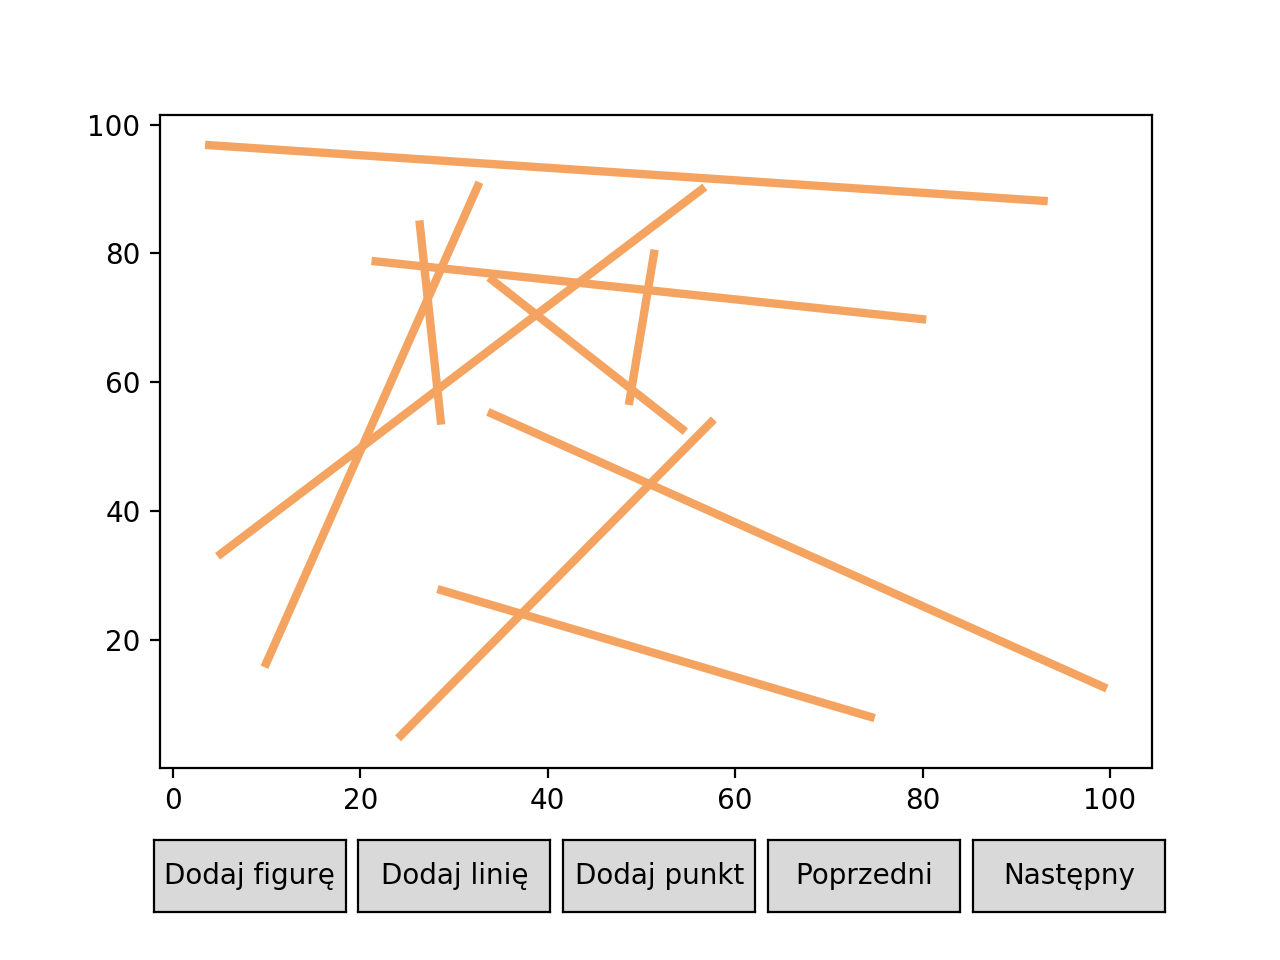

In [395]:
%matplotlib notebook
lines = get_random_lines(10)

plot = Plot(lines=[LinesCollection(lines, color='sandybrown', linewidth=3, zorder=0)])
plot.draw()

wprowadzanie odcinków za pomocą myszki

In [99]:
def get_drawn_lines(plot, file_name=None):
    '''
    funkcja zwracająca listę wprowadzonych odcinków na wykresie plot będącym instancją klasy Plot
    umożliwia zapis do pliku w postaci binarnej jeśli przekazano argument file_name
    '''
    
    lines = plot.get_added_lines()[0].lines
    
    if file_name:
        with open(file_name, 'wb') as f:
            pickle.dump(lines, f)
        
    return lines

In [100]:
def read_lines_from_file(file_name):
    '''
    funkcja do odczytu listy odcinków z pliku
    '''
    with open(file_name, 'rb') as f:
            return pickle.load(f)

<IPython.core.display.Javascript object>


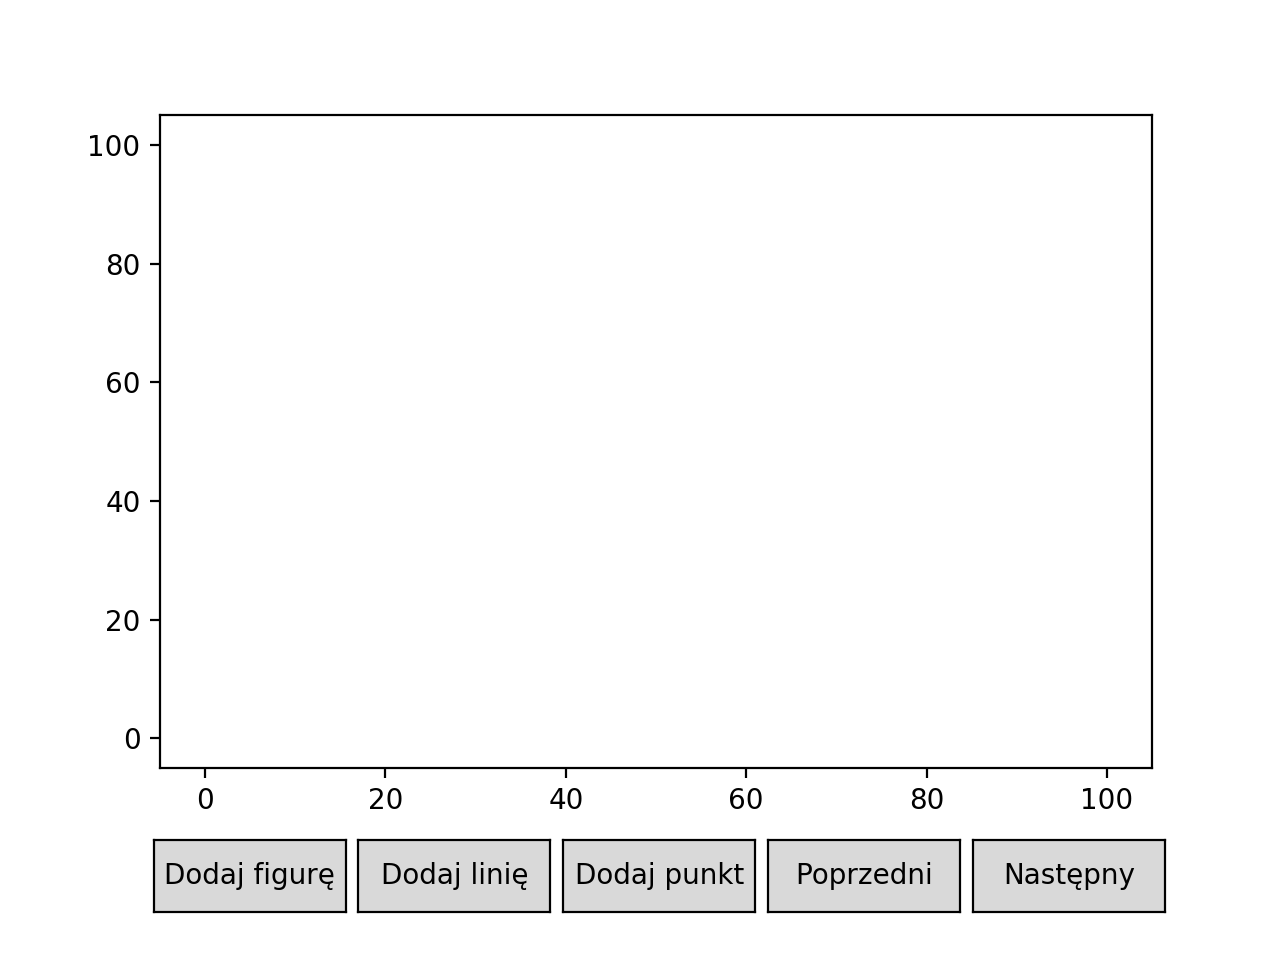

In [80]:
%matplotlib notebook

plot= Plot(lines=[LinesCollection([((0, 0), (100,100))], color='white')])
plot.draw()

zestawy punktów zaproponowane na zajęciach:

In [101]:
lines_1 = [[(16.882875504032256, 84.66040517769608), (85.18932711693549, 18.60648360906862)],
 [(12.669165826612904, 15.573395373774503), (83.63690776209677, 75.89815027573528)],
 [(22.64900453629032, 48.263346354166664),(37.72964969758065, 47.92633655024509)],
 [(60.57239163306452, 73.53908164828431), (63.455456149193544, 19.61751302083332)],
 [(70.99577872983872, 75.89815027573528), (72.54819808467741, 13.55133655024509)]]

In [102]:
lines_2 = [[(18.213520665322577, 28.716777726715684), (87.18529485887098, 31.412856158088225)],
 [(19.76594002016129, 48.263346354166664), (86.07642389112902, 57.02560125612745)],
 [(21.318359375, 73.87609145220588), (85.63287550403226, 75.89815027573528)],
 [(27.52803679435484, 87.01947380514704), (88.51594002016128, 88.36751302083334)],
 [(47.044165826612904, 97.46677772671566), (21.318359375, 13.214326746323522)],
 [(60.35061743951612, 98.81481694240196), (33.73771421370968, 10.181238511029399)],
 [(73.21352066532259, 98.14079733455881), (49.261907762096776, 11.529277726715677)],
 [(85.41110131048387, 97.46677772671566), (65.8949722782258, 6.4741306678921475)]]

### 2. Znajdowanie punktu przecięcia dwóch odcinków

In [103]:
def orientation(a, b, c, epsilon=1e-12):
    '''
    funkcja pomocnicza określająca pozycję punktu c względem a, b
    przy pomocy wyznacznika
    '''
    det = a[0]*b[1] + a[1]*c[0] + b[0]*c[1] - b[1]*c[0] - b[0]*a[1] - c[1]*a[0]
    if det > epsilon: return 1
    if det < -epsilon: return -1
    return 0


def intersect(line_1, line_2):
    '''
    zwraca True jeśli line_1 i line_2 się przecinają
    w przypadku, gdy koniec jednego odcinka leży na drugim odcinku, uznaje odcinki za przecinające się,
    odcinki równoległe, nakładające się na siebie nie przecinają się
    '''
    a, b = line_1
    c, d = line_2
    return orientation(c,d,a) != orientation(c, d, b) and orientation(a,b,c) != orientation(a,b,d)


def intersection(line_1, line_2):
    '''
    zwraca punkt przecięcia odcinków line_1 i line_2
    lub None jeśli się nie przecinają
    '''
    x1, y1 = line_1[0]
    x2, y2 = line_1[1]
    x3, y3 = line_2[0]
    x4, y4 = line_2[1]
    
    t_num = (x1-x3)*(y3-y4)-(y1-y3)*(x3-x4)
    den = (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4)
    
    if den == 0: # odcinki równoległe
        return None
    
    if t_num > den > 0 or t_num < den < 0: # punkt przecięcia prostych nie leży na line_1
        return None
    
    u_num = -((x1-x2)*(y1-y3) - (y1-y2)*(x1-x3))

    if u_num > den > 0 or u_num < den < 0: # punkt przecięcia prostych nie leży na line_2
        return None
    
    t = t_num/den
    
    return(x1 + t*(x2-x1), y1 + t*(y2-y1))

In [104]:
print(intersect(((0,0),(1,1)), ((1,1), (2,0))))
print(intersection(((0,0),(1,1)), ((1,1), (2,0))))

True
(1.0, 1.0)


### 3. Struktury stanu

* klasa reprezentująca odcinek w strukturze stanu

In [373]:
class Status_segment:
    def __init__(self, line):
        self.line = line
        self.a = (self.line[0][1]-self.line[1][1])/(self.line[0][0]-self.line[1][0])
        self.b = (self.line[0][1]-self.a*self.line[0][0])
    
    def __lt__(self, other):
        self_y = self.a * Status_segment.broom + self.b
        other_y = other.a * Status_segment.broom + other.b
        
        return self_y < other_y
    
    def __gt__(self, other):
        self_y = self.a * Status_segment.broom + self.b
        other_y = other.a * Status_segment.broom + other.b
        
        return self_y > other_y
    
    def __eq__(self, other):
        return self.line == other.line
    
    def __hash__(self):
        return hash(self.line)

* naiwna implemetacja struktury stanu na liście/tablicy
(wszystkie operacje mają złożoność liniową):

In [171]:
class Status_list:
    
    def __init__(self):
        self.list = []
        
        
    def add(self, x):
        i = 0
        while i < len(self.list) and x > self.list[i]:
            i += 1
            
        self.list.insert(i, x) 
        
    
    def remove(self, x):
        i = 0
        
        while i < len(self.list):
            if self.list[i] == x:
                del self.list[i]
                return
            i += 1   
    
    
    def succ(self, x):
        i = 0
        while i < len(self.list):
            if self.list[i] == x:
                if i == len(self.list)-1:
                    return None
                return self.list[i+1]
            i += 1
        
        
    def pred(self, x):
        i = 0
        while i < len(self.list):
            if self.list[i] == x:
                if i == 0:
                    return None
                return self.list[i-1]
            i += 1
            
        
    def __str__(self):
        return str(list(map(lambda x: x.line, self.list)))
    
    
    def get_lines(self):
        return list(map(lambda x: x.line, self.list))

* wydajna implementacja z wykorzystaniem struktury SortedSet z pakietu <i>sortedcontainers</i>

In [172]:
class Status_sorted_set:
    
    def __init__(self):
        self.set = SortedSet()
        
        
    def add(self, x):
        self.set.add(x)
    
    
    def remove(self, x):
        self.set.remove(x)
    
    
    def succ(self, x):
        index = self.set.index(x)
        if index == len(self.set)-1:
            return None
        return self.set[index+1]
      
        
    def pred(self, x):
        index = self.set.index(x)
        if index == 0:
            return None
        return self.set[index-1]
     
        
    def __str__(self):
        string = ""
        for line in self.set:
            string += str(line.line)
            string += ' '
        return string
    
    
    def get_lines(self):
        lines = []
        for line in self.set:
            lines.append(line.line)
        return lines

### 4. Istnienie pary odcinków przecinających się

* deklaracja stałych

In [108]:
START = 1
END = -1
INTERSECT = 0

* funkcja sprawdzająca, czy wśród zadanych odcinków jakiekolwiek dwa się przecinają, wraz z wizualizacją

In [116]:
def find_if_intersect_vis(lines, status_structure=Status_sorted_set):
    '''
    lines - lista odcinków na płaszczyźnie
    zwraca True jeśli istnieje para odcinków przecinających się
    oraz listę scen do wizualizacji
    '''
    
    min_y = inf
    max_y = -inf
    
    events = []
    
    for line in lines:
        a, b = line
        
        if a[0] > b[0]:
            a, b = b, a
        
        min_y = min([min_y, a[1], b[1]])
        max_y = max([max_y, a[1], b[1]])
        
        new_segment = Status_segment((a, b))
        
        events.append((a[0], new_segment, START))
        events.append((b[0], new_segment, END))
    
    segment_tree = Status_sorted_set()
    events.sort()
    
    min_x = events[0][0]
    max_x = events[-1][0]
    
    
    scenes = [Scene(points = [PointsCollection([(min_x-1, min_y-1), (max_x+1, max_y+1)], color='white')],
                    lines=[LinesCollection(lines, color='blue', zorder=0)])]
    
    for broom_x, line, event_type in events:
        Status_segment.broom = broom_x
        
        if event_type == START:
            Status_segment.broom = broom_x
            segment_tree.add(line)
            
            pred = segment_tree.pred(line)
            if pred:
                if intersect(pred.line, line.line):
                    scenes.append(Scene(points=[PointsCollection([intersection(pred.line, line.line)], color='purple'),
                                       PointsCollection([(min_x-1, min_y-1), (max_x+1, max_y+1)], color='white')], 
                            lines=[LinesCollection(lines, color='blue', zorder=0),
                                   LinesCollection([((broom_x, min_y-1), (broom_x, max_y+1))], color='pink'),
                                  LinesCollection([pred.line, line.line], color='midnightblue', zorder=10)]))
                    return True, scenes
                    
            succ = segment_tree.succ(line)
            if succ:
                if intersect(line.line, succ.line):
                    scenes.append(Scene(points=[PointsCollection([intersection(succ.line, line.line)], color='purple'),
                                       PointsCollection([(min_x-1, min_y-1), (max_x+1, max_y+1)], color='white')], 
                            lines=[LinesCollection(lines, color='blue', zorder=0),
                                   LinesCollection([((broom_x, min_y-1), (broom_x, max_y+1))], color='pink'),
                                  LinesCollection([succ.line, line.line], color='midnightblue', zorder=10)]))
                    return True, scenes
                    
        
        elif event_type == END:
                
            pred = segment_tree.pred(line)
            succ = segment_tree.succ(line)
            
            if pred and succ:
                if intersect(pred.line, succ.line):
                    scenes.append(Scene(points=[PointsCollection([intersection(pred.line, succ.line)], color='purple'),
                                       PointsCollection([(min_x-1, min_y-1), (max_x+1, max_y+1)], color='white')], 
                            lines=[LinesCollection(lines, color='blue', zorder=0),
                                   LinesCollection([((broom_x, min_y-1), (broom_x, max_y+1))], color='pink'),
                                  LinesCollection([pred.line, succ.line], color='midnightblue', zorder=10)]))
                    return True, scenes
              
            segment_tree.remove(line)
        
        scenes.append(Scene(points=[PointsCollection([(min_x-1, min_y-1), (max_x+1, max_y+1)], color='white')], 
                            lines=[LinesCollection(lines, color='blue', zorder=0),
                                   LinesCollection([((broom_x, min_y-1), (broom_x, max_y+1))], color='pink')]))
            
    return False, scenes

True


<IPython.core.display.Javascript object>


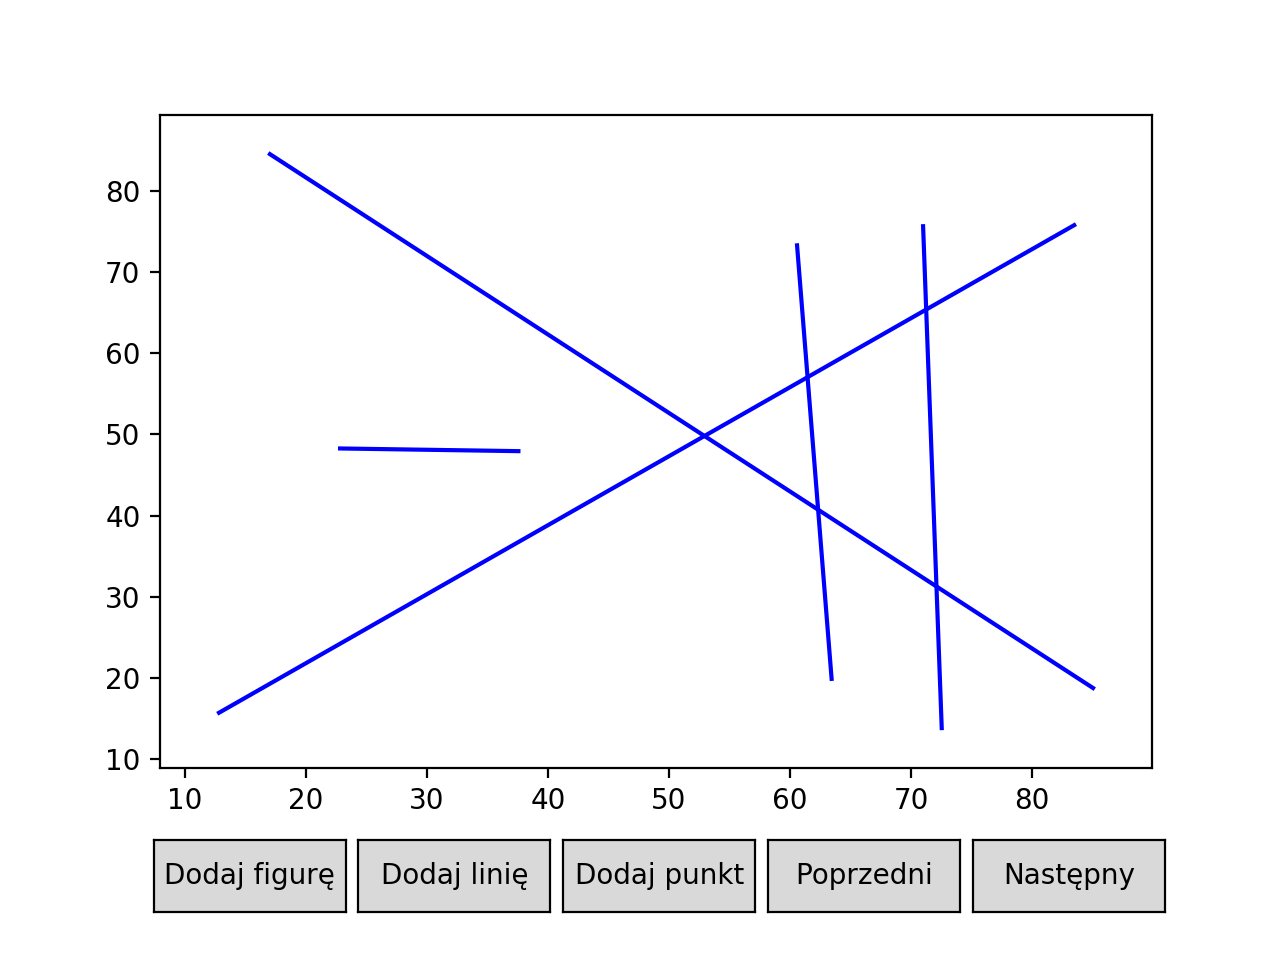

In [114]:
result, scenes = find_if_intersect_vis(lines_1, Status_sorted_set)
print(result)

plot = Plot(scenes=scenes)
plot.draw()

### 4. Znajdowanie wszystkich punktów przecięcia zadanych odcinków

In [396]:
def find_all_intersections_vis(lines, Status_data_structure=Status_sorted_set):
    '''
    zwraca:
        listę par odcinków przecinających się
        listę punktów przecięcia w korespondującej kolejności
        listę scen do wizualizacji
    '''
    
    intersections = []
    intersecting_set = set()
    event_queue = PriorityQueue()
    
    min_y = inf
    max_y = -inf
    min_x = inf
    max_x = -inf
    
    for line in lines:
        a, b = line
        
        if a[0] > b[0]:
            a, b = b, a
        
        min_y = min([min_y, a[1], b[1]])
        max_y = max([max_y, a[1], b[1]])
        min_x = min([min_x, a[0], b[0]])
        max_x = max([max_x, a[0], b[0]])
        
        new_segment = Status_segment((a, b))
        
        event_queue.put((a[0], a, new_segment, START))
        event_queue.put((b[0], b, new_segment, END))
    
    segment_tree = Status_data_structure()
    
    scenes = [Scene(points = [PointsCollection([(min_x-1, min_y-1), (max_x+1, max_y+1)], color='white')],
                    lines=[LinesCollection(lines, color='blue', zorder=0)])]
    
    while not event_queue.empty():
        broom_x, current_point, line, event_type = event_queue.get()
        
        if event_type == START:
            Status_segment.broom = broom_x
            segment_tree.add(line)
            
            pred = segment_tree.pred(line)
            if pred:
                if intersect(pred.line, line.line):
                    inter_point = intersection(pred.line, line.line)
                    
                    if (pred, line) not in intersecting_set and (line, pred) not in intersecting_set:
                        intersecting_set.add((pred, line))
                        intersections.append(inter_point)
                        event_queue.put((inter_point[0], inter_point, (pred, line), INTERSECT))
            
            
            succ = segment_tree.succ(line)
            if succ:
                if intersect(line.line, succ.line):
                    inter_point = intersection(line.line, succ.line)
                
                    if (succ, line) not in intersecting_set and (line, succ) not in intersecting_set:
                        intersecting_set.add((line, succ))
                        intersections.append(inter_point)
                        event_queue.put((inter_point[0], inter_point, (line, succ), INTERSECT))  
                                
            scenes.append(Scene(points=[PointsCollection([current_point], color='pink', zorder=100),
                                        PointsCollection(intersections[:], color='purple', zorder=20),
                                       PointsCollection([(min_x-1, min_y-1), (max_x+1, max_y+1)], color='white')], 
                            lines=[LinesCollection(segment_tree.get_lines(), color='midnightblue', zorder=10),
                                   LinesCollection(lines, color='blue', zorder=5),
                                   LinesCollection([((broom_x, min_y-1), (broom_x, max_y+1))], color='pink')]))
        
        elif event_type == END:
                
            pred = segment_tree.pred(line)
            succ = segment_tree.succ(line)
            
            if pred and succ:
                if intersect(pred.line, succ.line):
                    inter_point = intersection(pred.line, succ.line)
                    if (pred, succ) not in intersecting_set and (succ, pred) not in intersecting_set:
                        intersecting_set.add((pred, succ))
                        intersections.append(inter_point)
                        event_queue.put((inter_point[0], inter_point, (pred, succ), INTERSECT))
              
            segment_tree.remove(line)
            
            scenes.append(Scene(points=[PointsCollection([current_point], color='pink', zorder=100),
                                        PointsCollection(intersections[:], color='purple', zorder=20),
                                       PointsCollection([(min_x-1, min_y-1), (max_x+1, max_y+1)], color='white')], 
                            lines=[LinesCollection(lines, color='blue', zorder=5),
                                   LinesCollection([((broom_x, min_y-1), (broom_x, max_y+1))], color='pink'),
                                  LinesCollection(segment_tree.get_lines(), color='midnightblue', zorder=10)]))
        
        elif event_type == INTERSECT: 
            crossing_down, crossing_up = line
            
            Status_segment.broom = broom_x - 1e-10
            
            pred = segment_tree.pred(crossing_down)  
            if pred:
                if intersect(pred.line, crossing_up.line):
                    inter_point = intersection(pred.line, crossing_up.line)
                    if (pred, crossing_up) not in intersecting_set and (crossing_up, pred) not in intersecting_set:
                        intersecting_set.add((pred, crossing_up))
                        intersections.append(inter_point)
                        event_queue.put((inter_point[0], inter_point, (pred, crossing_up), INTERSECT))       
            
            
            succ = segment_tree.succ(crossing_up)
            if succ:
                if intersect(crossing_down.line, succ.line):
                    inter_point = intersection(crossing_down.line, succ.line)
                    if (crossing_down, succ) not in intersecting_set and (succ, crossing_down) not in intersecting_set:
                        intersecting_set.add((crossing_down, succ))
                        intersections.append(inter_point)
                        event_queue.put((inter_point[0], inter_point, (crossing_down, succ), INTERSECT))
            
                
            segment_tree.remove(crossing_down)
            segment_tree.remove(crossing_up)   
            
            Status_segment.broom = broom_x + 1e-10
            
            segment_tree.add(crossing_down)
            segment_tree.add(crossing_up)
            
            scenes.append(Scene(points=[PointsCollection([current_point], color='pink', zorder=100),
                                        PointsCollection(intersections[:], color='purple', zorder=20),
                                       PointsCollection([(min_x-1, min_y-1), (max_x+1, max_y+1)], color='white')], 
                            lines=[LinesCollection(lines, color='blue', zorder=5),
                                   LinesCollection([((broom_x, min_y-1), (broom_x, max_y+1))], color='pink'),
                                   LinesCollection(segment_tree.get_lines(), color='midnightblue', zorder=10)])) 
    
    scenes.append(Scene(points=[PointsCollection(intersections[:], color='purple', zorder=20),
                                       PointsCollection([(min_x-1, min_y-1), (max_x+1, max_y+1)], color='white')], 
                            lines=[LinesCollection(lines, color='blue', zorder=2)]))

    
    intersecting_lines = list(map(lambda x: (x[0].line, x[1].line), list(intersecting_set)))
    intersection_points = list(map(lambda x: intersection(x[0], x[1]), intersecting_lines))
        
    return intersecting_lines, intersection_points, scenes

intersecting lines:
 [(((12.669165826612904, 15.573395373774503), (83.63690776209677, 75.89815027573528)), ((60.57239163306452, 73.53908164828431), (63.455456149193544, 19.61751302083332))), (((12.669165826612904, 15.573395373774503), (83.63690776209677, 75.89815027573528)), ((70.99577872983872, 75.89815027573528), (72.54819808467741, 13.55133655024509))), (((12.669165826612904, 15.573395373774503), (83.63690776209677, 75.89815027573528)), ((16.882875504032256, 84.66040517769608), (85.18932711693549, 18.60648360906862))), (((16.882875504032256, 84.66040517769608), (85.18932711693549, 18.60648360906862)), ((70.99577872983872, 75.89815027573528), (72.54819808467741, 13.55133655024509))), (((16.882875504032256, 84.66040517769608), (85.18932711693549, 18.60648360906862)), ((60.57239163306452, 73.53908164828431), (63.455456149193544, 19.61751302083332)))]
points of intersection:
 [(61.45443367756783, 57.04236769377279), (71.25778946011546, 65.37552045684828), (52.93311634738636, 49.79898689

<IPython.core.display.Javascript object>


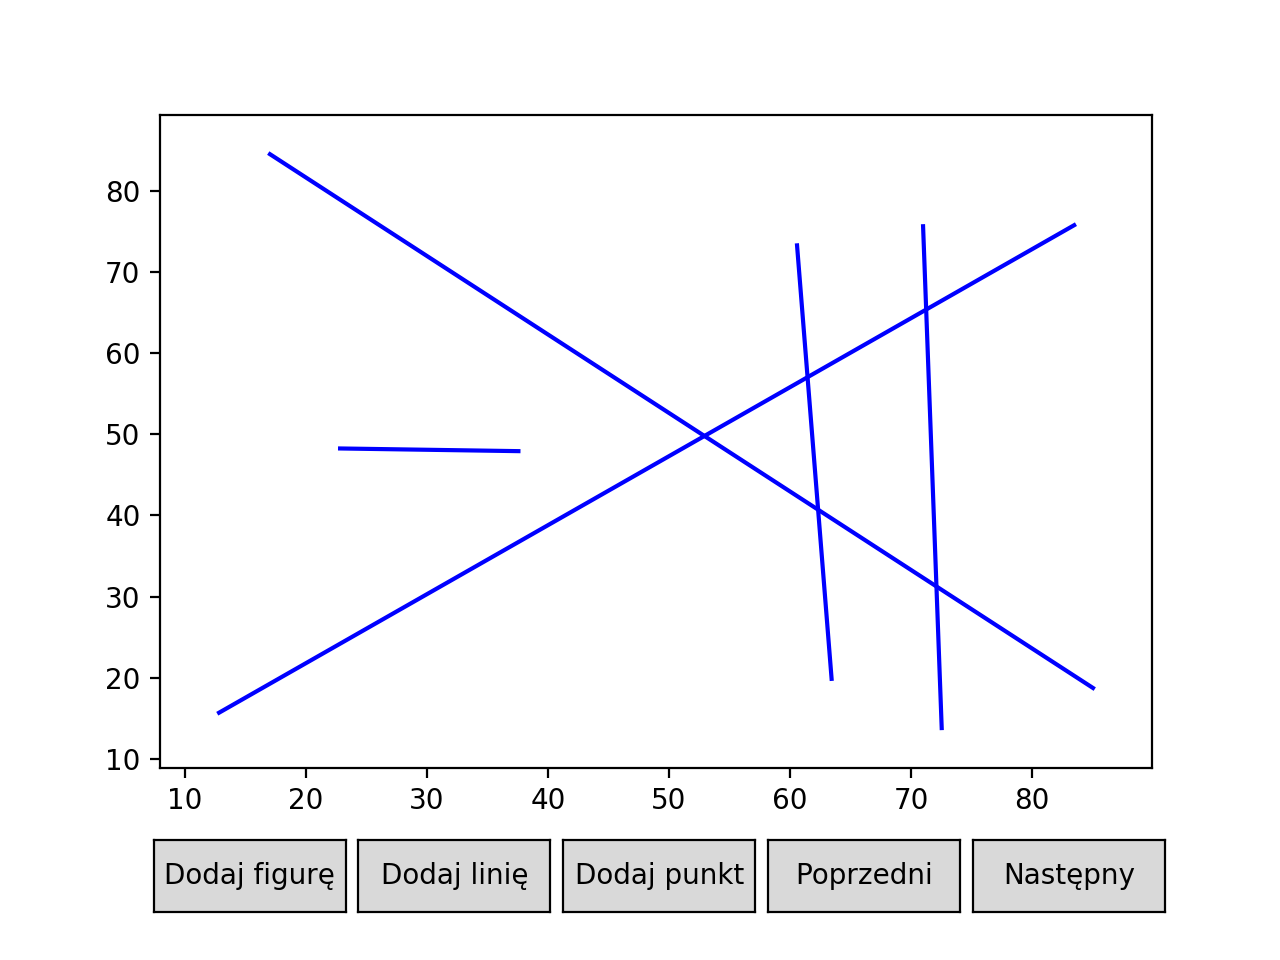

In [397]:
lines, points, scenes = find_all_intersections_vis(lines_1, Status_sorted_set)
print("intersecting lines:\n", lines)
print("points of intersection:\n", points)
print("number of points of intersection: ", len(points))
plot = Plot(scenes=scenes)
plot.draw()

<IPython.core.display.Javascript object>


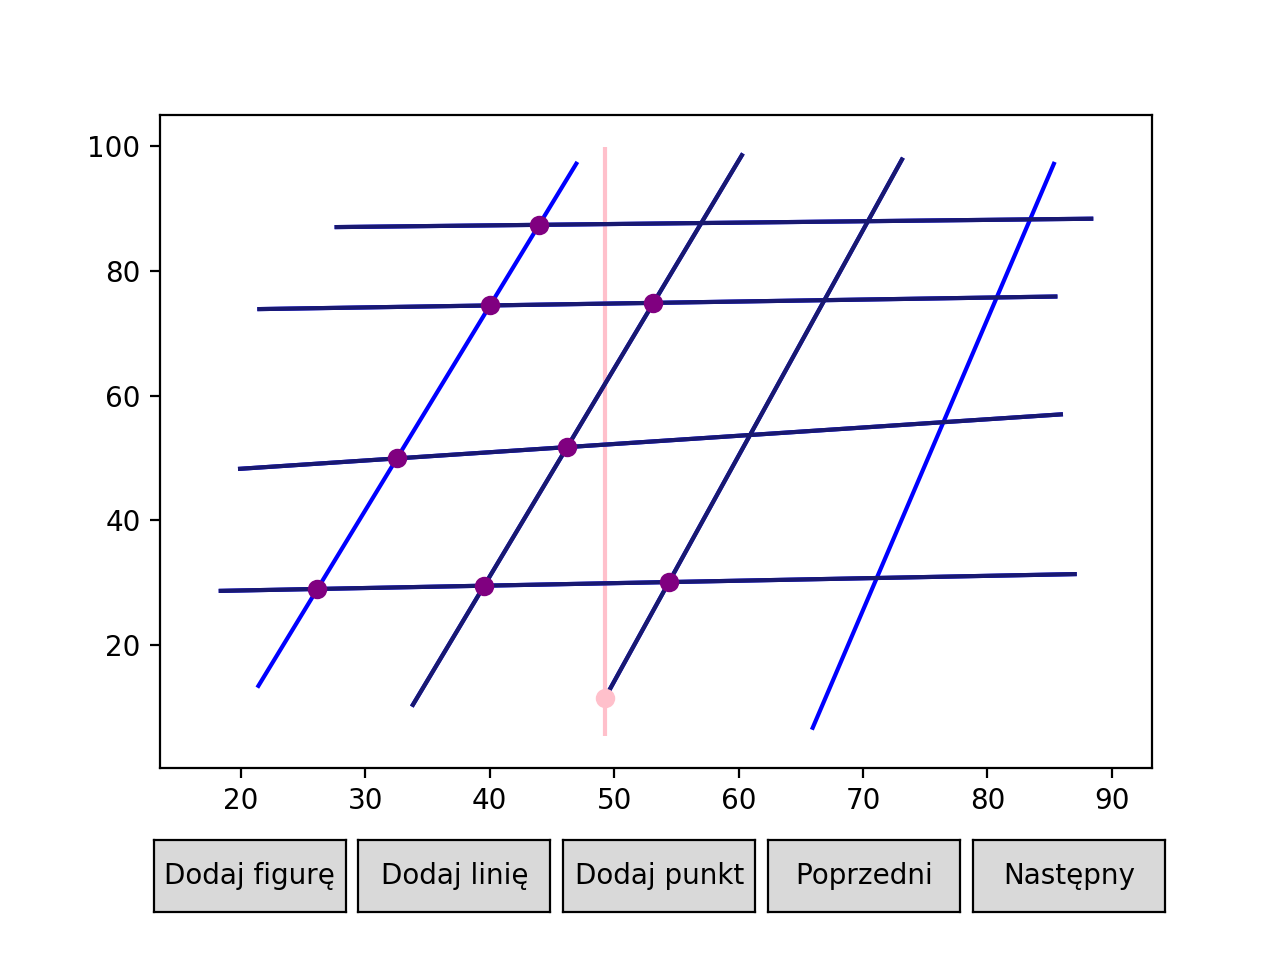

In [398]:
lines, points, scenes = find_all_intersections_vis(lines_2, Status_sorted_set)
plot = Plot(scenes=scenes)
plot.draw()

In [336]:
random_lines = get_random_lines(10)

<IPython.core.display.Javascript object>


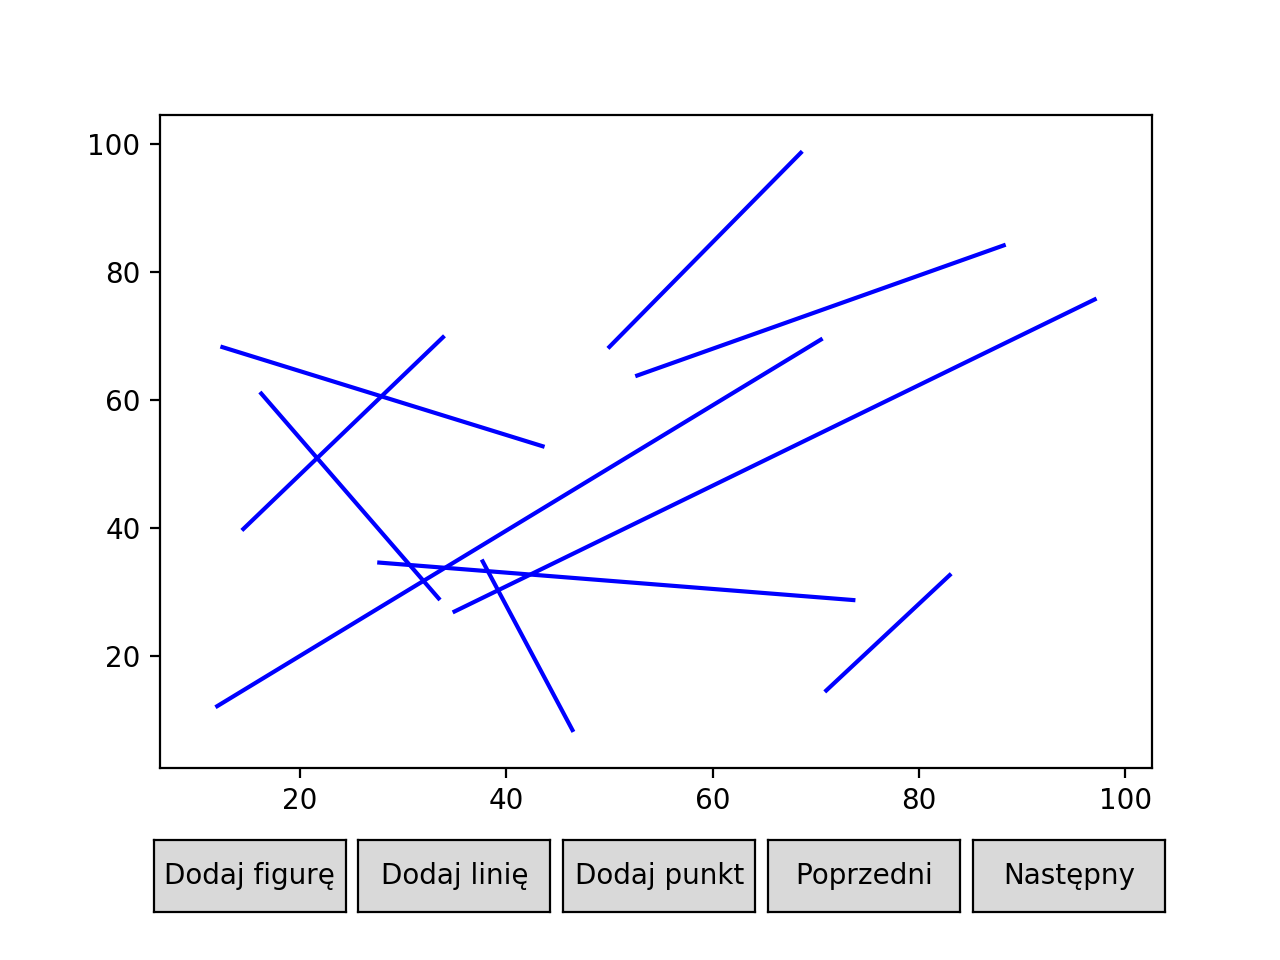

In [364]:
lines, points, scenes = find_all_intersections_vis(random_lines, Status_sorted_set)
plot = Plot(scenes=scenes)
plot.draw()

### 5. Animacje

In [342]:
# lines, points, scenes = find_all_intersections_vis(random_lines)
# for i, scene in enumerate(scenes):
#     plot = Plot(scenes=[scene])
#     plot.draw()
#     plt.savefig(f'plot_inter_3/{i}')

objaśnienie wizualizacji:
* <font color='pink'>różowa pionowa linia to aktualna miotła </font>
* <font color='pink'>różowy punkt to aktualnie analizowany punkt zdarzenia </font>
* <font color='midnightblue'> ciemnogranatowo zaznaczono odcinki znajdujące się w strukturze stanu po wykonaniu algorytmu w zaznaczonej pozycji miotły </font>
* <font color='blue'>na niebiesko odcinki, których prztewarzanie jeszcze się nie rozpoczęło lub już się skończyło</font>
* <font color='purple'>na fioletowo znalezione punkty przecięcia </font>

<img src="animacja_1.gif">
<img src="animacja_2.gif">
<img src="animacja_3.gif">

### 6. Porównanie czasu działania programu dla różnych struktur stanu

poniższa funkcja posłuży mi do pomiaru czasu działania algorytmu dla różnych struktur stanu

In [399]:
def find_all_time(lines, Status_data_structure=Status_sorted_set):
    '''
    argument Status_data_structure to klasa struktury stanu
    zwraca czas wykonania programu dla zadanych linii i danej struktury stanu
    '''
    
    start = time()
    
    intersecting_set = set()
    event_queue = PriorityQueue()
    
    for line in lines:
        a, b = line
        
        if a[0] > b[0]:
            a, b = b, a
        
        new_segment = Status_segment((a, b))
        
        event_queue.put((a[0], a, new_segment, START))
        event_queue.put((b[0], b, new_segment, END))
    
    
    segment_tree = Status_data_structure()
    
    
    while not event_queue.empty():
        broom_x, current_point, line, event_type = event_queue.get()
        
        if event_type == START:
            Status_segment.broom = broom_x
            segment_tree.add(line)
            
            pred = segment_tree.pred(line)
            if pred:
                if intersect(pred.line, line.line):
                    inter_point = intersection(pred.line, line.line)
                    
                    if (pred, line) not in intersecting_set and (line, pred) not in intersecting_set:
                        intersecting_set.add((pred, line))
                        event_queue.put((inter_point[0], inter_point, (pred, line), INTERSECT))
            
            
            succ = segment_tree.succ(line)
            if succ:
                if intersect(line.line, succ.line):
                    inter_point = intersection(line.line, succ.line)
                
                    if (succ, line) not in intersecting_set and (line, succ) not in intersecting_set:
                        intersecting_set.add((line, succ))
                        event_queue.put((inter_point[0], inter_point, (line, succ), INTERSECT))  
                                
        
        elif event_type == END:
                
            pred = segment_tree.pred(line)
            succ = segment_tree.succ(line)
            
            if pred and succ:
                if intersect(pred.line, succ.line):
                    inter_point = intersection(pred.line, succ.line)
                    if (pred, succ) not in intersecting_set and (succ, pred) not in intersecting_set:
                        intersecting_set.add((pred, succ))
                        event_queue.put((inter_point[0], inter_point, (pred, succ), INTERSECT))
              
            segment_tree.remove(line)

        
        elif event_type == INTERSECT: 
            crossing_down, crossing_up = line
            
            Status_segment.broom = broom_x - 1e-10
            
            pred = segment_tree.pred(crossing_down)  
            if pred:
                if intersect(pred.line, crossing_up.line):
                    inter_point = intersection(pred.line, crossing_up.line)
                    if (pred, crossing_up) not in intersecting_set and (crossing_up, pred) not in intersecting_set:
                        intersecting_set.add((pred, crossing_up))
                        event_queue.put((inter_point[0], inter_point, (pred, crossing_up), INTERSECT))       
            
            
            succ = segment_tree.succ(crossing_up)
            if succ:
                if intersect(crossing_down.line, succ.line):
                    inter_point = intersection(crossing_down.line, succ.line)
                    if (crossing_down, succ) not in intersecting_set and (succ, crossing_down) not in intersecting_set:
                        intersecting_set.add((crossing_down, succ))
                        event_queue.put((inter_point[0], inter_point, (crossing_down, succ), INTERSECT))
            
                
            segment_tree.remove(crossing_down)
            segment_tree.remove(crossing_up)   
            
            Status_segment.broom = broom_x + 1e-10
            
            segment_tree.add(crossing_down)
            segment_tree.add(crossing_up)
            
    end = time()  
    return end - start

In [400]:
def count_time():
    for n in [10, 50, 100, 150, 200, 250, 500, 1000]:
        print()
        print(n)
        lines = get_random_lines(n)
        print("list: ", find_all_time(lines, Status_list))
        print("sorted set: ", find_all_time(lines, Status_sorted_set))
        print()

M. Hawryluk AGH 2020